# Wholesale Customers Analysis

## Introduction

The aim of this project is to analyze customers by their spendings on different kinds
of product categories as a wholesale distributor.

The data set is available at https://archive.ics.uci.edu/ml/datasets/Wholesale+customers.

* Firstly, the data set has been read from the file.
* Data has been preprocessed. 
    - Channel and Region columns have been dropped.
    - Logarithmic scaling has been applied on the data.
* Dimensionality reduction (using PCA) has been performed on the data set.
* Clustering algorithms have been run on the data set.


Some import statements used in the whole project are written below.
The others will be imported when necessary.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading the data from the csv file and describing it to have a quick glance.

In [2]:
data = pd.read_csv('wholesale_data.csv')
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [3]:
data.shape

(440, 8)

Data set consists of 440 data points with 8 features. Two of them, Channel and Region seem to be categorical.
We won't use them in this project.

## Data Preprocessing

First of all, I want to check for null values. If there exists some, I must fill them with dummy values.

In [4]:
for col in data.columns:
    null_values = data.loc[data[col] == pd.isnull, data.columns].empty
    if not null_values:
        print(data.loc[data[col] == pd.isnull, data.columns])

Well, it seems clear. Then, I want to visualise the data to really see it, just out of curiousity.

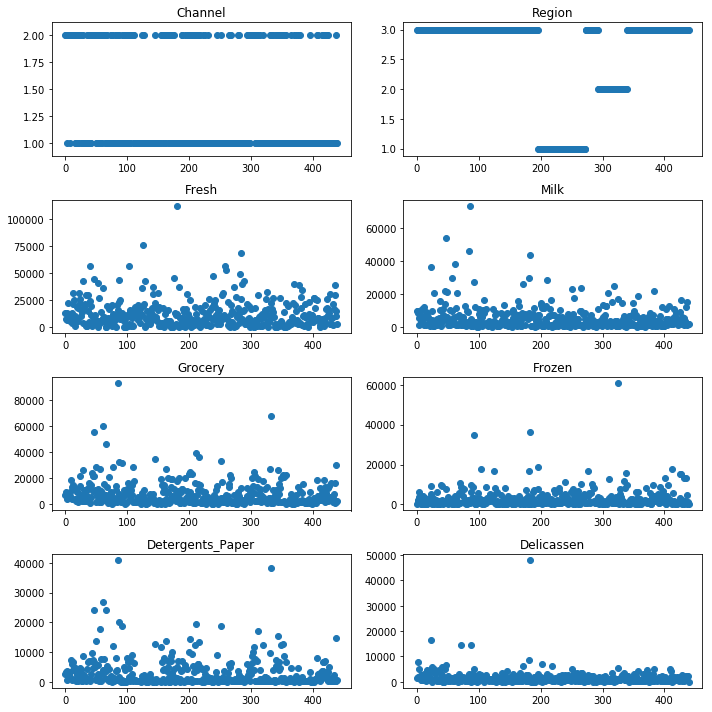

In [5]:
for i, col in enumerate(data.columns.values):
    plt.subplot(4, 2, i+1)
    plt.scatter([i for i in range(440)], data[col].values.tolist())
    plt.title(col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

As I said earlier, I will drop the two nominal columns:

In [6]:
data = data.drop(['Region', 'Channel'], axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [7]:
data.shape

(440, 6)

Good, they are gone now. To implement dimensionality reduction with PCA, I must scale the data.

For this purpose, I will apply logarithmic scaling on the data.

Additionally, I will delete some of the data points as they are stated as outliers in my assignment paper.

In [8]:
log_data = np.log(data)
good_data = log_data.drop([128, 65, 66, 75, 154])
print(good_data.head())

       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0   9.446913  9.175335  8.930759  5.365976          7.891331    7.198931
1   8.861775  9.191158  9.166179  7.474205          8.099554    7.482119
2   8.756682  9.083416  8.946896  7.785305          8.165079    8.967504
3   9.492884  7.086738  8.347827  8.764678          6.228511    7.488853
4  10.026369  8.596004  8.881558  8.272571          7.482682    8.553525


## Dimensionality Reduction

Now it is time to implement PCA to the data set.

But, before that, I will investigate the explained variance ratio and resulting principal components:

In [9]:
from sklearn.decomposition import PCA
pca = PCA().fit(good_data)
print(pca.explained_variance_ratio_)
print()
print(good_data.columns.values.tolist())
print(pca.components_)

[ 0.44302505  0.26379218  0.1230638   0.10120908  0.04850196  0.02040793]

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
[[ 0.16746374 -0.40143866 -0.43811142  0.17820975 -0.75142613 -0.14987105]
 [-0.68593522 -0.16722783 -0.07072902 -0.50054207 -0.04244398 -0.49414702]
 [-0.67738927  0.04020501 -0.01953317  0.31504299 -0.21170161  0.62855082]
 [-0.204293    0.01281068  0.05567564  0.78544905  0.20961368 -0.54233972]
 [-0.00261356  0.71923846  0.3553861  -0.0330861  -0.55815441 -0.20918629]
 [ 0.02915623 -0.54018269  0.82053348  0.02054106 -0.18238824  0.01974794]]


First two components seem to cover around 70% of the data.

If we care about the values with a threshold of absolute distance from 0 such as 0.5, we can draw conclusions like these:

* First component seems to care about the lack of 'Detergents_Paper' spendings more than anything. This component is likely a measure of 'Detergents_Paper'.
* Second component is mostly interested in the lack of 'Fresh' and 'Frozen' spendings. These two increase or decrease together.
* The third component is mainly cares 'Delicateessen' and the lack of 'Fresh' spendings and they are negatively related. 
* In the fourth one, most important features seem to be 'Frozen' and the lack of 'Delicateessen'. They are inversely related.
* Fifth one cares about 'Milk' and the lack of 'Detergents_Paper' spendings while sixth principal component is interested in 'Grocery' and the lack of 'Milk' spendings.

To see the variance in a cumulative manner, I will plot a step graph like below:

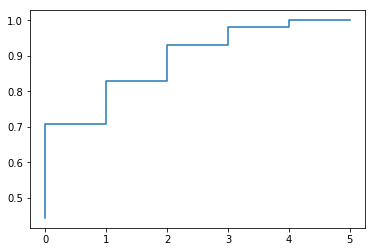

In [10]:
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))], cumulative)
plt.show()

This plot too shows that 70% of the data can be expressed by the first two principal components.

So, I will apply PCA to the data with number of components = 2.

The reduced data can be seen on the plotting below.

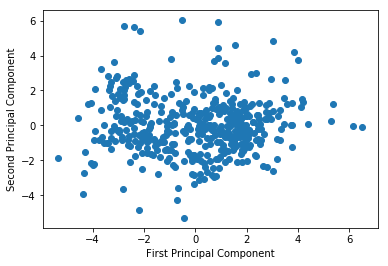

In [11]:
pca = PCA(n_components=2)
pca.fit(good_data)
reduced_data = pca.transform(good_data)
inverse_data = pca.inverse_transform(reduced_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label='reduced')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

According to the principal components,
data points with greater values on the x-axis represent the customers that are less likely to spend to Detergents_Paper category.

Likewise, data points with greater values on the y-axis represent the customers that are less likely to spend to Fresh and Frozen categories.

Now, I can constitute a DataFrame out of my reduced data with two dimensions:

In [12]:
reduced_data = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])

## Clustering

It is time to cluster the data so that we can extract information from them related to the customer
annual spending behaviors.

### K-Means

I will run K-Means starting from k=2 to k=10.

I will collect the silhouette scores for each of the results. So that I can determine the best number of clusters.

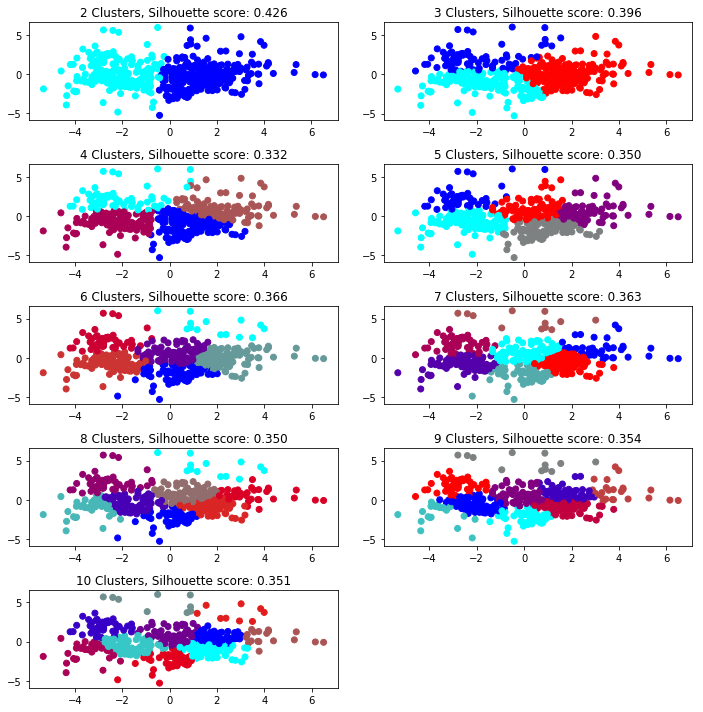

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('BlRd', ['blue', 'red', 'cyan'])

silhouette_scores = []
for i in range(2, 11):
    cl = KMeans(n_clusters=i, random_state=0)
    result = cl.fit_predict(reduced_data)
    silhouette = silhouette_score(reduced_data, result)
    silhouette_scores.append(silhouette)
    plt.subplot(5, 2, i-1)
    plt.scatter(reduced_data.Dim1.values, reduced_data.Dim2.values, c=result, cmap=cmap)
    plt.title(str(i) + ' Clusters, Silhouette score: ' + str(silhouette)[:5])
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

So colorful. Now I will plot a graph for the collected silhouette scores:

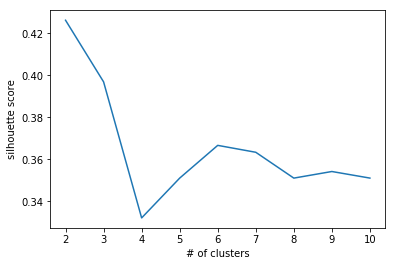

In [14]:
plt.plot([i for i in range(2, 11)], silhouette_scores)
plt.xlabel('# of clusters')
plt.ylabel('silhouette score')
plt.show()

The best number of clusters seem to be 2 (or maybe 3) in this case. So, I will save the corresponding plot for the later usage:

In [15]:
cl = KMeans(n_clusters=2, random_state=0)
result = cl.fit_predict(reduced_data)
silhouette = silhouette_score(reduced_data, result)
plt.clf()
plt.scatter(reduced_data.Dim1.values, reduced_data.Dim2.values, c=result, cmap=cmap)
plt.title(str(2) + ' Clusters, Silhouette score: ' + str(silhouette)[:5])
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5, 5)
plt.tight_layout()
plt.savefig('img/kmeans_fav.png')

### Hierarchical Clustering

Here are the results of running hierarchical clustering on the data set. I will try all linkage methods possible
to see the differences. Then I will plot dendrograms and clusters side by side.

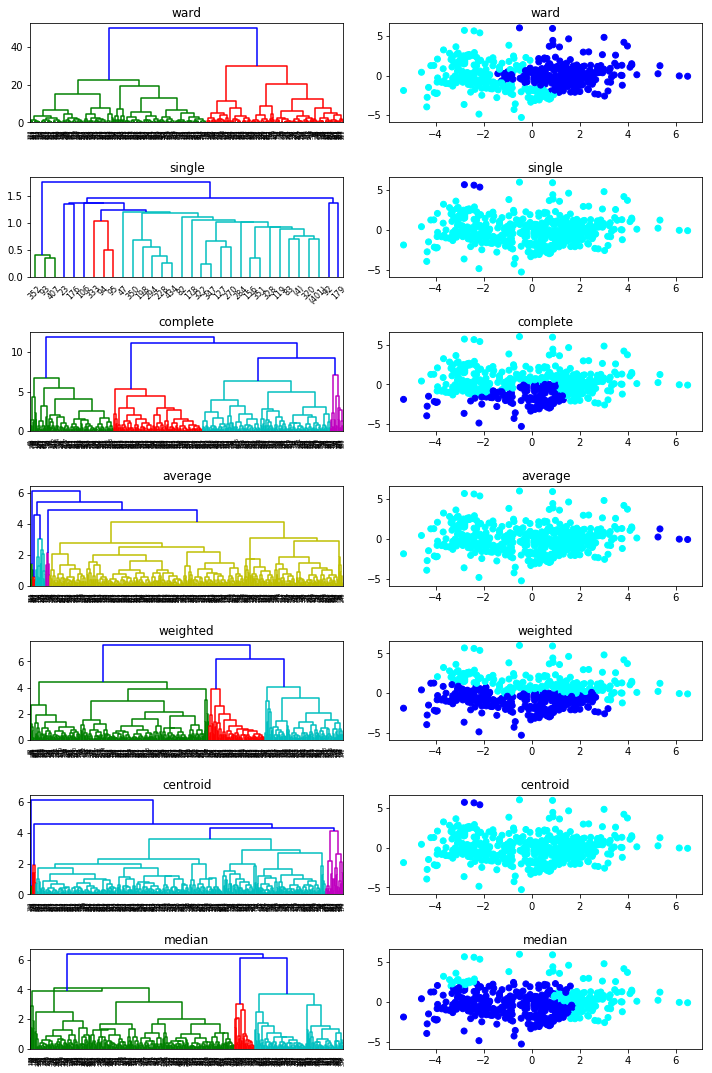

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

methods = ['ward', 'single', 'complete', 'average',
           'weighted', 'centroid', 'median']
plot_id = 0
for method in methods:
    cl = linkage(reduced_data, method=method)
    
    for sw in ['dendrogram', 'clusters']:
        if sw == 'dendrogram':
            plot_id += 1
            plt.subplot(7, 2, plot_id)
            plt.title(method)
            fig, ax = plt.gcf(), plt.gca()
            dn = dendrogram(cl, truncate_mode='level', p=15)
            plt.tight_layout()
            fig.set_size_inches(10, 15)
        else:
            plot_id += 1
            labels = fcluster(cl, 2, criterion='maxclust')
            plt.subplot(7, 2, plot_id)
            plt.title(method)
            plt.scatter(reduced_data.Dim1.values.tolist(),
               reduced_data.Dim2.values.tolist(),
               cmap=cmap,
               c=labels
            )      
plt.show()

So, I want to stick with the 'weighted' one. Because of the reason stated below.

Also, please be reminded that the above dendrograms are truncated for visualisation purposes at maximum of 15 levels.

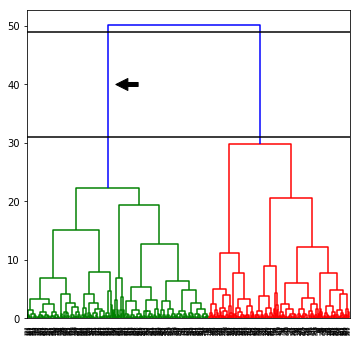

In [17]:
cl = linkage(reduced_data, method='ward')
fig, ax = plt.gcf(), plt.gca()
dn = dendrogram(cl, truncate_mode='level', p=15)
plt.tight_layout()
fig.set_size_inches(5, 5)
plt.axhline(y=31, c='k')
plt.axhline(y=49, c='k')
ax.annotate('', xy=(1200, 40), xytext=(1500, 40),
           arrowprops={'facecolor': 'black'})
plt.show()

This maximum of 20 seems to be a good distance for clustering. Doing so, we should have 2 clusters. I am saving the plot:

In [18]:
cl = linkage(reduced_data, method='ward')
labels = fcluster(cl, 2, criterion='maxclust')
plt.scatter(reduced_data.Dim1.values.tolist(),
   reduced_data.Dim2.values.tolist(),
   cmap=cmap,
   c=labels
)  
plt.savefig('img/hierarchical_fav.png')

cl = linkage(reduced_data, method='weighted')
labels = fcluster(cl, 2, criterion='maxclust')
plt.scatter(reduced_data.Dim1.values.tolist(),
   reduced_data.Dim2.values.tolist(),
   cmap=cmap,
   c=labels
)  
plt.savefig('img/hierarchical_fav2.png')

### DBSCAN

Here is the toughest one. I will run this algorithm for epsilons 0.3 through 0.9 with step size of 0.2 and for minimum number of samples 3 through 8 with one increment per step.

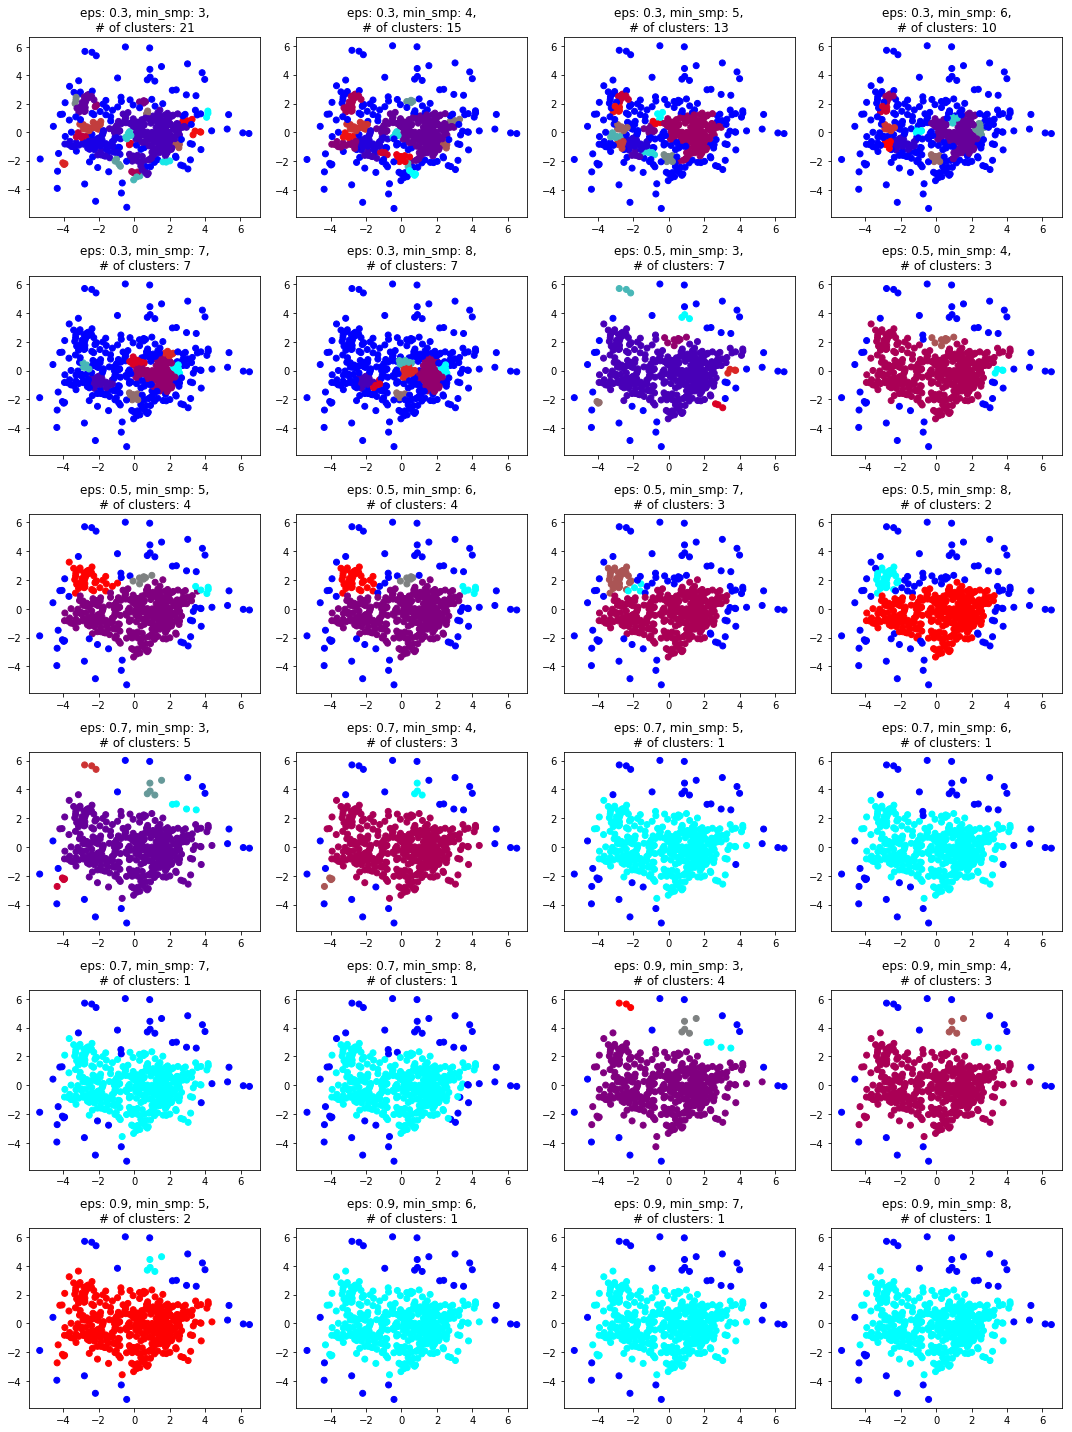

In [19]:
from sklearn.cluster import DBSCAN

plot_id = 0
for eps in np.arange(0.3, 0.9, 0.2):
    for min_samples in range(3, 9):
        plot_id += 1
        cl = DBSCAN(eps=eps, min_samples=min_samples)
        result = cl.fit_predict(reduced_data)
        n_clusters = len([c for c in list(set(result)) if c != -1])
        plt.subplot(6, 4, plot_id)
        plt.scatter(reduced_data.Dim1.values.tolist(),
           reduced_data.Dim2.values.tolist(),
           cmap=cmap,
           c=result
        )
        fig, ax = plt.gcf(), plt.gca()
        fig.set_size_inches(15, 20)
        plt.title('eps: ' + str(eps) +\
                  ', min_smp: ' + str(min_samples) +\
                 ',\n# of clusters: ' + str(n_clusters))
        plt.tight_layout()
plt.show()

None of them resembles the previous results with other algorithms to me.

I think the last one, with one big group at the center may be useful since it groups customers that are like spending together and leaves the ones as outliers.

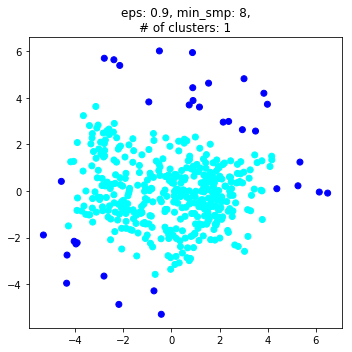

In [20]:
cl = DBSCAN(eps=0.9, min_samples=8)
result = cl.fit_predict(reduced_data)
n_clusters = len([c for c in list(set(result)) if c != -1])
plt.scatter(reduced_data.Dim1.values.tolist(),
   reduced_data.Dim2.values.tolist(),
   cmap=cmap,
   c=result
)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5, 5)
plt.title('eps: ' + str(eps) +\
          ', min_smp: ' + str(min_samples) +\
         ',\n# of clusters: ' + str(n_clusters))
plt.tight_layout()
plt.savefig('img/dbscan_fav.png')
plt.show()

## Conclusion

Now that we have applied three clustering algorithms on the problem, we then interpret the resulting clusters. So that, the wholesale distributor may take necessary actions for each types of customers.

![K-Means](img/kmeans_fav.png)

The 'K-Means' image is the result of K-Means clustering. In this case, the first principal component (which cares Detergent_Paper) slices the customers into two (into two groups of course). So, labeling the data set according to the Detergent_Paper spendings like Detergent_Paper_Customer = 1 if the customer is in the left group and 0 otherwise may lead us a new supervised data set. Then further work should be maintained in the supervised area as new customers appears on the data set by time.

![Hierarchical](img/hierarchical_fav.png)

The 'Hierarchical' is the result of hierarchical clustering. Similar to result of K-Means algorithm but, this one tends to assign customers who are likely to spend on Fresh and Frozen categories and less likely to spend on Detergents_Paper category to the left group. 

Something similar happens to those customers who tend to spend on Detergents_Paper but not likely to spend on Fresh and Frozen too much.

According to this figure, same labeling with K-Means can be made on the data set for the further work.

Altough this clustering was the best choice according to its dendrogram, this one is also interesting (Hierarchical 2):

![Hierarchical 2](img/hierarchical_fav2.png)

Roughly, it separates the customers by the second principal component. Maybe not very convenient but, as an alternative, the data set may be labeled with customers' Fresh and Frozen spendings. Then the problem becomes a supervised one again.

![Dbscan](img/dbscan_fav.png)

DBSCAN grouped the dense fields on the plane. According to the result, there is a big group of customers whose spending habits are similar. Whereas there are outliers around it, who have spending habits different than this big group. The wholesale distributor may count them as special customers and treat them differently according to their special spending habits.